In [66]:
# data sources from fangraphs.com via the pybaseball module

from pybaseball import batting_stats
from sklearn import neighbors
from sklearn.model_selection import train_test_split


In [67]:
# df_base = batting_stats(2015, 2022)
# df_base.to_csv("batting_stats_15_22.csv")
import pandas as pd
df_base = pd.read_csv("batting_stats_15_22.csv")


In [68]:
# don't include the 2020 covid shortened season
df = df_base.drop(df_base[df_base['Season'] == 2020].index)



In [69]:

# we select a few stats that account for different ballpark metrics, as well as average exit 
# velocity for hits 

# batting average+ (+ meaning 100 is average, 115 is 15% better than aveage), walks, strikeouts,
# isolated power (a rate at which the player hits for extra bases, measuring power), average 
# exit velocity of hits, line drive rate+, ground ball rate +, fly ball rate+
X = df[['AVG+', 'BB%+', 'K%+', 'ISO+', 'EV', 'LD+%', 'GB%+', 'FB%+']]

# our output will be Wins over Average Replacement- a measure of how much better a player is in terms
# of an average replacement in the minor leagues, measured in wins
y = df[['WAR']]

In [70]:
# creating train test splits
SEED=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [71]:
from sklearn.preprocessing import StandardScaler

# scaling all features 
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
from sklearn.metrics import mean_squared_error

# hyperparameter tuning for k - lets find smallest RMSE for 100 values of k
rmse_values = list()
rmse_values_in_sample = list()

for k in range(1,501):
    reg = neighbors.KNeighborsRegressor(n_neighbors=k)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse_values.append(mean_squared_error(y_test, y_pred)**(1/2))

    y_pred_in_sample = reg.predict(X_train)
    rmse_values_in_sample.append(mean_squared_error(y_train, y_pred_in_sample)**(1/2))

## Examining RMSE

With our data prepared and our model fitted for many trial values of k, we now focus on our biggest concern- complexity. Since we are already regressing data from several different features, this issue is already more important than one with fewer features, as we have to think about the curse of dimensionality. 

Plotting our in-sample and out-of-sample RMSE, we see the familiar pattern of the curves diverging at lower complexity and converging at higher values. Upon examination, we can identify the minimum value for out-of-sample RMSE at `1.520` with `k=7` - much smaller than the simpler models we've looked at in our modules!

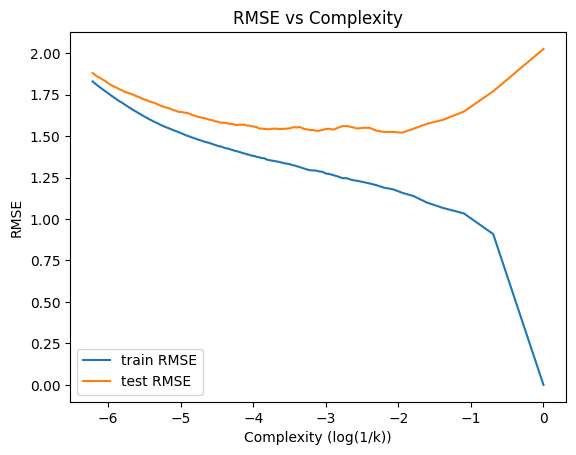

In [63]:
import numpy as np
import matplotlib.pyplot as plt

a = [np.log(1/x) for x in range(1,501)]
a.reverse()

# plt.figure(1,figsize=(15,5))
# plt.subplot(121)
plt.plot(a, rmse_values_in_sample[::-1],label='train RMSE')
plt.plot(a, rmse_values[::-1],label='test RMSE')
plt.title('RMSE vs Complexity')    
plt.xlabel('Complexity (log(1/k))')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Examining our final model
Fitting with k=7, we'll start looking a little at our sample in detail. For fun, lets run the lineup for our hometown team through the model and see how it likes how our players are looking! 

Since all our features are rate statistics - as opposed to counting stats (like number of hits, home runs, etc), this is doable even for a partial season! According to fangraphs.com, my favorite player, Corbin Carroll, is projected to finish the season at 4.7 WAR- a likely all-star pace. Our model is a little more bullish, pegging him at 4.9 (bearing in mind the 1.52 RMSE of course).

In [65]:
def predict_player(df,reg, scaler, player_name):
     p = df[df["Name"] == player_name][['AVG+', 'BB%+', 'K%+', 'ISO+', 'EV', 'LD+%', 'GB%+', 'FB%+']]
     p = scaler.transform(p)
     p_pred = reg.predict(p)
     print(f"{player_name}: {p_pred}")

# df2 = batting_stats(2023, qual=25)
# df2.to_csv("batting_stats_2023.csv")

df2 = pd.read_csv("batting_stats_2023.csv")

roster = ["Corbin Carroll","Geraldo Perdomo","Lourdes Gurriel Jr.","Ketel Marte","Christian Walker","Dominic Fletcher","Gabriel Moreno",
          "Josh Rojas","Emmanuel Rivera","Evan Longoria","Nick Ahmed","Pavin Smith","Kyle Lewis","Jake McCarthy","Alek Thomas"]
reg = neighbors.KNeighborsRegressor(n_neighbors=7)
reg.fit(X_train, y_train)

for p in roster:
    try:
        predict_player(df2, reg, scaler, p)
    except ValueError:
        print(f"Player '{p}' not found in dataset")


Corbin Carroll: [[4.95714286]]
Geraldo Perdomo: [[4.68571429]]
Lourdes Gurriel Jr.: [[5.27142857]]
Ketel Marte: [[3.68571429]]
Christian Walker: [[3.58571429]]
Dominic Fletcher: [[2.94285714]]
Gabriel Moreno: [[2.12857143]]
Josh Rojas: [[0.78571429]]
Emmanuel Rivera: [[4.4]]
Evan Longoria: [[1.5]]
Nick Ahmed: [[1.14285714]]
Pavin Smith: [[1.81428571]]
Player 'Kyle Lewis' not found in dataset
Jake McCarthy: [[0.51428571]]
Alek Thomas: [[0.62857143]]


I've also plotted a quick histogram of our our predicted vs. actual y values in our test set, as a sanity check. We should expect to see a distribution with a peak around 2, with a somewhat longer tail on the upper end (generally, an average major leaguer should be worth around 2 WAR for an entire season, above 4 being all-star range, and above 7 being a Most Valuable Player pace).

Fortunately, this seems to be the case. An interesting observation is that our model seems to be a bit more conservative in its prediction, with a generally lower variance. 


Text(0.5, 1.0, 'predicted WAR in test sample')

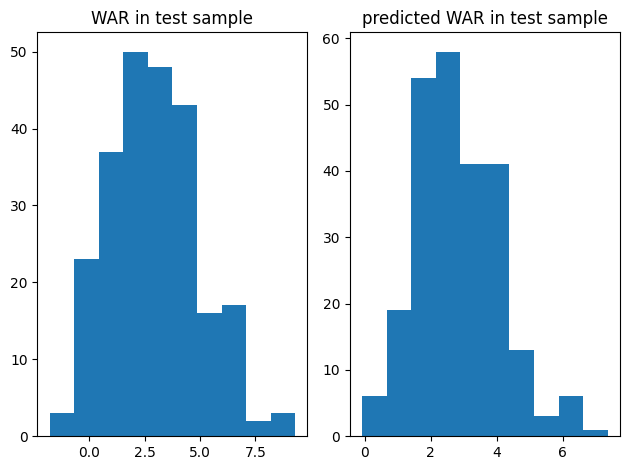

In [72]:
y_pred_final = reg.predict(X_test)

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(y_test)
axs[0].set_title("WAR in test sample")
axs[1].hist(y_pred_final)
axs[1].set_title("predicted WAR in test sample")